### Import mujoco and numpy

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class HopperDynamics(object):
    def __init__(self, dt=0.1) -> None:
        self._m  = 0.1
        # self._I = np.diag([1.0, 1.0, 1.0])
        self._g  = 9.81 
        self._dt = dt

        def manip_eq(xk1, xk, uk):
            pk, pkdot = xk[0], xk[1]
            pk1, pk1dot = xk1[0], xk1[1]
            f, b = uk[0], uk[1]
            return ca.vertcat(
                pk-pk1+self._dt*pk1dot,
                self._m*(pk1dot-pkdot) + self._dt*(self._g*self._m-b-f)
            )

        def dfdt(x, u):
            p, pdot = x[0], x[1]
            f, b = u[0], u[1]
            pddot = (f+b)/self._m - self._g
            return ca.vertcat(pdot, pddot) 
        def f(x, u):
            return x + self._dt * self.dfdt(x, u)
        self.manip_eq = manip_eq
        self.dfdt = dfdt 
        self.f = f 

hopper_model = HopperDynamics()

def loss(x, u):
    return ca.sumsqr(x-np.array([5.,0.]))
# ca.sumsqr(u) + 
def phi(x):
    return x[0]

In [3]:
x  = ca.SX.sym('x', 2)
u  = ca.SX.sym('u', 2)

In [4]:
xnext = hopper_model.f(x, u)
F = ca.Function('F',[x,u], [xnext])#, ['x, y'], ['ode1', 'ode2'])

In [ ]:
opti = ca.Opti()
tf = 5
N = int(tf/hopper_model._dt)
x = opti.variable(2, N+1) # Decision variables for state trajetcory
u = opti.variable(2, N)
p  = opti.parameter(2, 1)  # initial cond Parameter (not optimized over)
pf = opti.parameter(2,1)
opti.minimize(loss(x,u))

for k in range(N):
  # opti.subject_to(x[:,k+1]==hopper_model.f(x[:,k],u[:,k]))
  opti.subject_to(hopper_model.manip_eq(x[:,k+1],x[:,k],u[:,k])==0)
  opti.subject_to(phi(x[:,k+1])>=0)
  opti.subject_to((phi(x[:,k+1])*u[0,k])==0)
  opti.subject_to(u[0,k]>=0)
  # opti.subject_to(u[1,k]<=0)

opti.subject_to(opti.bounded(-1,u[1,:],0))
opti.subject_to(x[:,0]==p) #np.array([2.,0.]))
# opti.subject_to(u>=0)
# opti.subject_to(x[:,-1]==pf) #np.array([10.,0.]))


In [ ]:
p_opts = {"expand": True}
s_opts = {"max_iter": 100000}
opti.solver('ipopt', p_opts, s_opts)

# And choose a concrete value for p
opti.set_value(p, [5.,0.])
# opti.set_value(pf, [1.1 ,0.])
sol = opti.solve()

This is Ipopt version 3.14.5, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      452
Number of nonzeros in inequality constraint Jacobian.:      150
Number of nonzeros in Lagrangian Hessian.............:      152

Total number of variables............................:      202
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      152
Total number of inequality constraints...............:      150
        inequality constraints with only lower bounds:      100
   inequality constraints with lower and upper bounds:       50
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2750000e+03 5.00e+00 1.00e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

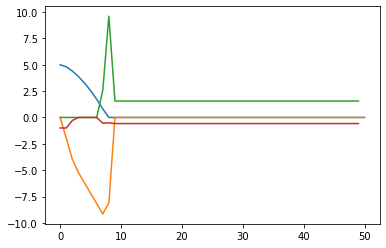

In [ ]:
# plt.plot(opti.debug.value(x).T)
# plt.plot(opti.debug.value(u).T)

plt.plot(sol.value(x).T)
plt.plot(sol.value(u).T)

In [153]:
sol.stats

<bound method OptiSol.stats of OptiSol(Opti {
  instance #28
  #variables: 2 (nx = 202)
  #parameters: 1 (np = 2)
  #constraints: 251 (ng = 302)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})>

In [3]:
def ineq_constr(x, args):
    q = x[:,:2]
    f = x[:,2:]
    _phi_out = vmap(phi)(q)
    return jnp.concatenate([-_phi_out, -f[:,0]])

def eq_constr(x, args):
    q = x[:,:2]
    f = x[:,2:]
    q0 = args['q0']
    qf = args['qf']
    _phi_out = vmap(phi)(q)
    return jnp.concatenate([
        (q[0] - q0).flatten(),
        (q[1:,:]-vmap(hopper_model.f)(q[:-1,:], f[:-1,:])).flatten(),
        (_phi_out*f[:,0]).flatten(),
        (q[-1] - qf).flatten()
    ])

In [4]:
args = {
    'q0' : np.array([5.,0.]),
    'qf' : np.array([10.,0.]) 
}

def loss(x, args):
    q, f = x[:,:2], x[:,2:]
    return jnp.array(0.)#jnp.mean(f**2)


In [5]:
time_horizon = int(6/hopper_model._dt)
# q = jnp.linspace(args['q0'], args['qf'], time_horizon, endpoint=True)
q = jnp.zeros((time_horizon, 2))
u = jnp.zeros((time_horizon, 1))
x = jnp.concatenate([q, u], axis=1)

In [6]:
opt_solver = AugmentedLagrangian(x, loss, eq_constr, ineq_constr, args=args, step_size=1e-3, c=1.0)

In [7]:
opt_solver.solve(eps=1e-5)

False

In [8]:
sol = opt_solver.get_solution()

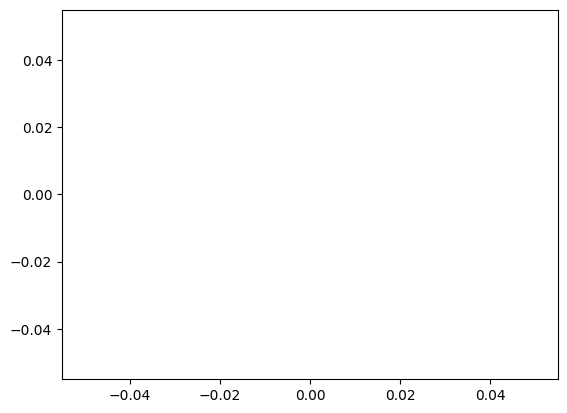

In [12]:
plt.plot(sol['x'][:,0])

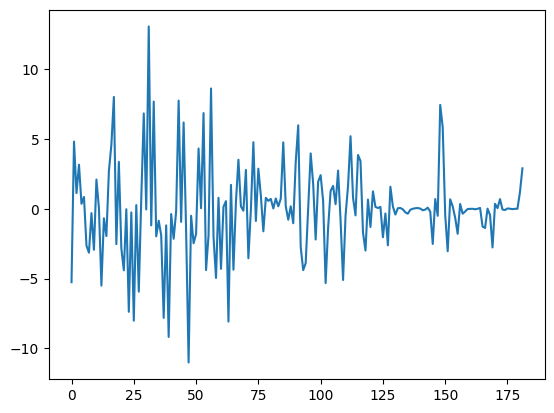

In [35]:
plt.plot(eq_constr(sol['x'], args))

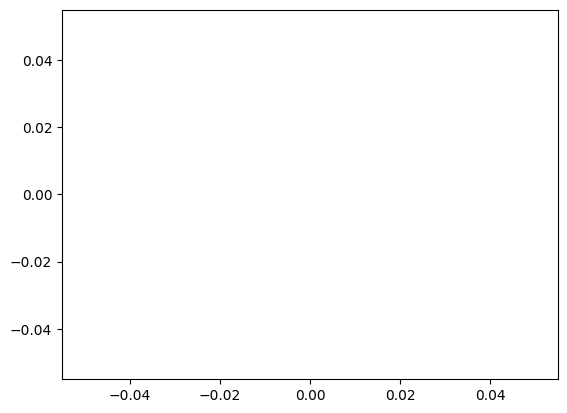

In [25]:
plt.plot(sol['x'])